# Reweight samples according to covariate density

In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im


# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.neighbors import KernelDensity




from typing import Iterable
from pathlib import Path



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

In [2]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend', 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [3]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
technologies = technology_groups[techno]


# ---------- Merge + label prep ----------
train_df, test_df, feature_names, target_columns, integer_encoding = im.preprocess_data(failure_data_path=failure_data_file,
                                                                            weather_data_path=weather_data_file,
                                                                            power_load_data_path=power_load_file,
                                                                            feature_names=feature_names_base,
                                                                            cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                            state_one_hot=False,
                                                                            technology_one_hot=False,
                                                                            initial_MC_state_filter='A',
                                                                            technology_filter=technologies,
                                                                            test_periods=test_periods,
                                                                            keep_initial_state=True
                                                                            )


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

39 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Technology', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']
Standardized features (33): ['FDD', '24h_min_load', 'FDD3d', '1d_load_sum', 'Precip_1d', 'Heat_index', 'HDD', 'Extreme_heat', 'Wind_chill', 'Technology', 'Precip_3d', 'Station_level_pressure', 'HDD3d', 'Tmean', 'Wet_bulb_temperature', 'Wind_speed', 'CDD3d', 'Precipitation', 'Load', 'CDD', 'Pressure_3hr_change', 'State', '2d_load_sum', 'Tmax', 'Dew_point_temperature', 'Sea_level_pressure', 'Hourly_load_change', 'Tmin', 'Extreme_cold'

# One feature

In [63]:
X = train_df[['Temperature']].to_numpy()

In [64]:
kde = KernelDensity(kernel='gaussian', bandwidth=(X.max() - X.min())/10)

kde.fit(X)

,bandwidth,np.float32(0.8158649)
,algorithm,'auto'
,kernel,'gaussian'
,metric,'euclidean'
,atol,0
,rtol,0
,breadth_first,True
,leaf_size,40
,metric_params,None


In [121]:
X_interp = np.quantile(X.flatten(), np.concat([np.linspace(0, 0.02,25), np.linspace(0.025,0.975,50),np.linspace(0.98, 1,25)])).reshape(-1, 1)
log_density = kde.score_samples(X_interp)

In [124]:
X_interp2 = np.quantile(X.flatten(),np.linspace(0,1,100)).reshape(-1, 1)
log_density2 = kde.score_samples(X_interp)

In [125]:
X_interp3 = np.linspace(X.min(),X.max(),100)
log_density3 = kde.score_samples(X_interp)

In [127]:
prob = np.exp(log_density)
weights = 1/prob

prob2= np.exp(log_density2)
weights2 = 1/prob

prob3 = np.exp(log_density3)
weights3 = 1/prob

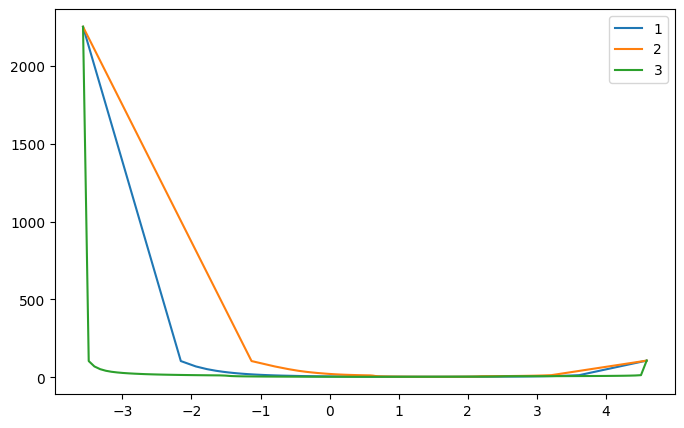

In [128]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(X_interp, weights,  markersize=2, label='1')
ax.plot(X_interp2, weights2,  markersize=2, label='2')
ax.plot(X_interp3, weights3,  markersize=2, label='3')
# ax2 = ax.twinx()
# ax2.plot(X_interp, np.exp(log_density), color='red', linewidth=2, label='KDE')
ax.legend()

In [69]:
all_weights = np.interp(X.flatten(), X_interp.flatten(), weights)

In [70]:
all_weights

array([  3.47465523,   3.47465523,   3.47465523, ..., 267.18328465,
       267.18328465, 267.18328465], shape=(17264738,))

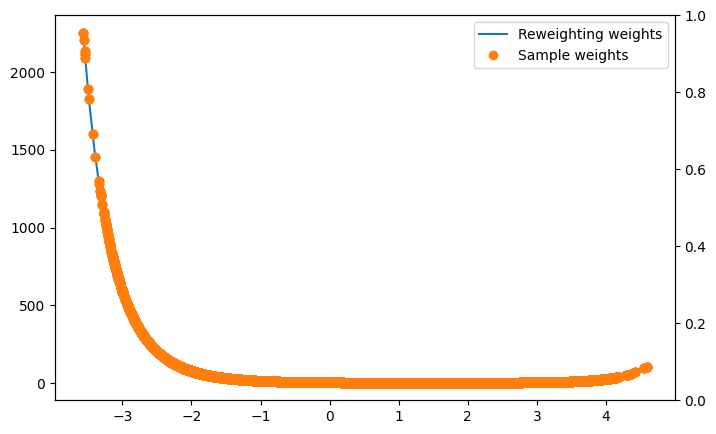

In [71]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(X_interp, weights,  markersize=2, label='Reweighting weights')
ax.plot(X, all_weights, 'o', label='Sample weights')
ax2 = ax.twinx()
# ax2.plot(X_interp, np.exp(log_density), color='red', linewidth=2, label='KDE')

ax.legend()

In [90]:
m = all_weights/all_weights.mean()

In [91]:
all_weights.sum()/len(X)

np.float64(5.030318579976691)

In [87]:
len(X)

17264738

In [89]:
all_weights.mean()

np.float64(5.030318579976691)

In [94]:
m.min()

np.float64(0.6770125318599938)

# Test

In [7]:
importlib.reload(im)
dataset_subset = train_df.iloc[:1000, :].copy()

mlp = im.MLP(verbose=True)
mlp.build_model(feature_cols=feature_names, 
                target_cols=target_columns, 
                num_classes=3,
                hidden_sizes=[100, 100, 100, 50], activations=['relu', 'relu', 'relu', 'relu'])

mlp.prepare_data(dataset_subset, train_ratio=0.80, val_ratio=0.1, standardize=stand_cols, reweight_train_data_density='Temperature')

Sequential(
  (linear_0): Linear(in_features=45, out_features=100, bias=True)
  (activation_0): ReLU()
  (linear_1): Linear(in_features=100, out_features=100, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (activation_3): ReLU()
  (linear_out): Linear(in_features=50, out_features=3, bias=True)
)
Input dim: 45 | Output dim: 3 | Trainable params: 30,003


In [8]:
mlp.train_model(optimizer='adam', loss='cross_entropy',
                regularization_type='L2', lambda_reg=1e-3,
                weights_data=True,
                epochs=10, batch_size=10, lr=2e-4, device='cpu')

Starting MLP training...
Epoch 001: train=5.7819e-01 | val=2.9572e-02
Epoch 002: train=7.8092e-03 | val=2.0897e-03
Epoch 003: train=3.8125e-03 | val=7.9062e-04
Epoch 004: train=4.9922e-03 | val=5.6429e-04
Epoch 005: train=4.1202e-03 | val=4.4358e-04
Epoch 006: train=2.5575e-03 | val=3.1329e-04
Epoch 007: train=3.3004e-03 | val=2.6055e-04
Epoch 008: train=2.5396e-03 | val=2.3408e-04
Epoch 009: train=2.3762e-03 | val=1.7264e-04
Epoch 010: train=2.8008e-03 | val=2.2343e-04


In [11]:
importlib.reload(im)

# dataset_subset = dataset#.iloc[:1000, :].copy()

xgb_model = im.xgboostModel(verbose=True)
xgb_model.build_model(max_depth=6,
                      eta=0.07,
                      gamma=0.8,
                      reg_lambda=1,
                      num_boost_round=100,
                      feature_cols=feature_names,
                      target_cols=target_columns,
                      num_classes=3,
                      eval_metric='mlogloss', # rmse, logloss, mae, mape
                      objective='multi:softprob',
                      subsample=1)

xgb_model.prepare_data(dataset_subset, train_ratio=0.80, val_ratio=0.1, standardize=stand_cols, reweight_train_data_density='Temperature')
xgb_model.train_model(weights_data=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=10,
              enable_categorical=False, eta=0.07, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.8,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)
[0]	validation_0-mlogloss:0.99648
[1]	validation_0-mlogloss:0.90699
[2]	validation_0-mlogloss:0.82788
[3]	validation_0-mlogloss:0.75745
[4]	validation_0-mlogloss:0.69440
[5]	validation_0-mlogloss:0.63769
[6]	validation_0-mlogloss:0.58647
[7]	validation_